<a href="https://colab.research.google.com/github/nantawat23308/TreeModelSegment/blob/main/Tree_Model_Customer_Segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost, umap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy.stats import mode

In [4]:
path_data = r"/content/drive/MyDrive/customer_segment/Train.csv"

In [5]:
data = pd.read_csv(path_data, index_col = 0)

In [6]:
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


# Data Preparing

In [7]:
data.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [8]:
data.isna().sum()

,0
Gender,0
Ever_Married,140
Age,0
Graduated,78
Profession,124
Work_Experience,829
Spending_Score,0
Family_Size,335
Var_1,76
Segmentation,0


In [9]:
data = data.drop('Work_Experience', axis = 1)
data = data.loc[~pd.isna(data['Profession']), :]

In [10]:
input_data = data.iloc[:, :-1]
output_data = data.iloc[:, -1]

In [11]:
categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

In [12]:
input_data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Spending_Score,Family_Size,Var_1
ID,,,,,,,,
462809,Male,No,22,No,Healthcare,Low,4.0,Cat_4
462643,Female,Yes,38,Yes,Engineer,Average,3.0,Cat_4
466315,Female,Yes,67,Yes,Engineer,Low,1.0,Cat_6
461735,Male,Yes,67,Yes,Lawyer,High,2.0,Cat_6
462669,Female,Yes,40,Yes,Entertainment,High,6.0,Cat_6


In [13]:
output_data.head()

,Segmentation
ID,
462809,D
462643,A
466315,B
461735,B
462669,A


In [14]:
imputed_data = input_data.copy()
imputed_data[categorical_features] = imputed_data[categorical_features].fillna(imputed_data[categorical_features].mode().iloc[0])
imputed_data['Family_Size'] = imputed_data['Family_Size'].fillna(imputed_data['Family_Size'].mean()).astype(int)
imputed_data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Spending_Score,Family_Size,Var_1
ID,,,,,,,,
462809,Male,No,22,No,Healthcare,Low,4,Cat_4
462643,Female,Yes,38,Yes,Engineer,Average,3,Cat_4
466315,Female,Yes,67,Yes,Engineer,Low,1,Cat_6
461735,Male,Yes,67,Yes,Lawyer,High,2,Cat_6
462669,Female,Yes,40,Yes,Entertainment,High,6,Cat_6


In [15]:
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7944 entries, 462809 to 461879
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          7944 non-null   object
 1   Ever_Married    7944 non-null   object
 2   Age             7944 non-null   int64 
 3   Graduated       7944 non-null   object
 4   Profession      7944 non-null   object
 5   Spending_Score  7944 non-null   object
 6   Family_Size     7944 non-null   int64 
 7   Var_1           7944 non-null   object
dtypes: int64(2), object(6)
memory usage: 558.6+ KB


In [16]:
formatted_data = imputed_data.copy()
formatted_data['Gender'] = (imputed_data['Gender'] == 'Male').astype(int)
formatted_data['Ever_Married'] = (imputed_data['Ever_Married'] == 'Yes').astype(int)
formatted_data['Graduated'] = (imputed_data['Graduated'] == 'Yes').astype(int)
formatted_data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Spending_Score,Family_Size,Var_1
ID,,,,,,,,
462809,1,0,22,0,Healthcare,Low,4,Cat_4
462643,0,1,38,1,Engineer,Average,3,Cat_4
466315,0,1,67,1,Engineer,Low,1,Cat_6
461735,1,1,67,1,Lawyer,High,2,Cat_6
462669,0,1,40,1,Entertainment,High,6,Cat_6


In [17]:
dummies = pd.get_dummies(formatted_data['Var_1'], prefix = 'Var_1', prefix_sep = ':')
formatted_data = pd.concat([formatted_data.drop('Var_1', axis = 1), dummies], axis = 1)
formatted_data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Spending_Score,Family_Size,Var_1:Cat_1,Var_1:Cat_2,Var_1:Cat_3,Var_1:Cat_4,Var_1:Cat_5,Var_1:Cat_6,Var_1:Cat_7
ID,,,,,,,,,,,,,,
462809,1,0,22,0,Healthcare,Low,4,False,False,False,True,False,False,False
462643,0,1,38,1,Engineer,Average,3,False,False,False,True,False,False,False
466315,0,1,67,1,Engineer,Low,1,False,False,False,False,False,True,False
461735,1,1,67,1,Lawyer,High,2,False,False,False,False,False,True,False
462669,0,1,40,1,Entertainment,High,6,False,False,False,False,False,True,False


In [18]:
dummies = pd.get_dummies(formatted_data['Profession'], prefix = 'Profession', prefix_sep = ':')
formatted_data = pd.concat([formatted_data.drop('Profession', axis = 1), dummies], axis = 1)
formatted_data.head()

,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size,Var_1:Cat_1,Var_1:Cat_2,Var_1:Cat_3,Var_1:Cat_4,...,Var_1:Cat_7,Profession:Artist,Profession:Doctor,Profession:Engineer,Profession:Entertainment,Profession:Executive,Profession:Healthcare,Profession:Homemaker,Profession:Lawyer,Profession:Marketing
ID,,,,,,,,,,,,,,,,,,,,,
462809,1,0,22,0,Low,4,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
462643,0,1,38,1,Average,3,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
466315,0,1,67,1,Low,1,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
461735,1,1,67,1,High,2,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
462669,0,1,40,1,High,6,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [19]:
formatted_data['Spending_Score'] = formatted_data['Spending_Score'].map({'Low':0, 'Average':1, 'High':2})
formatted_data.head()

,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size,Var_1:Cat_1,Var_1:Cat_2,Var_1:Cat_3,Var_1:Cat_4,...,Var_1:Cat_7,Profession:Artist,Profession:Doctor,Profession:Engineer,Profession:Entertainment,Profession:Executive,Profession:Healthcare,Profession:Homemaker,Profession:Lawyer,Profession:Marketing
ID,,,,,,,,,,,,,,,,,,,,,
462809,1,0,22,0,0,4,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
462643,0,1,38,1,1,3,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
466315,0,1,67,1,0,1,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
461735,1,1,67,1,2,2,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
462669,0,1,40,1,2,6,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


# PCA

In [20]:
pca_model = PCA(random_state = 25).fit(formatted_data)

In [21]:
len(formatted_data.columns)

22

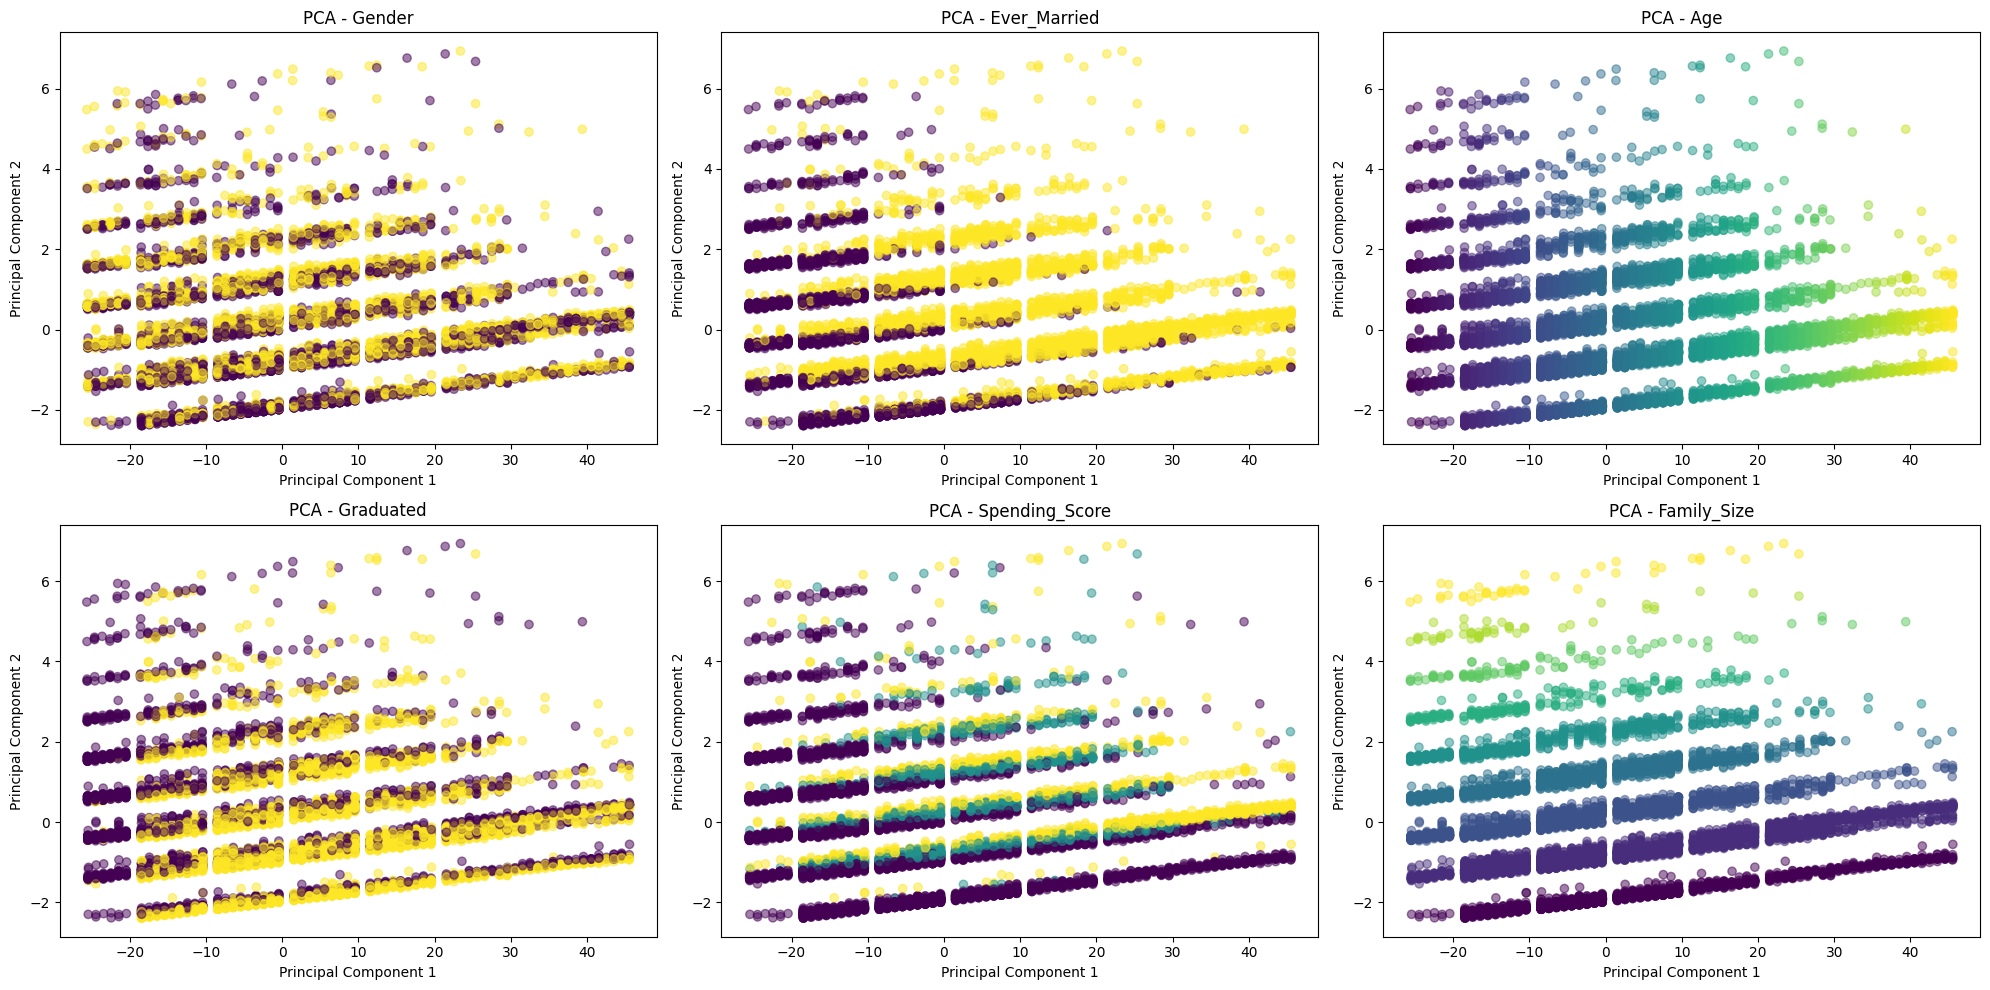

In [22]:
pca_embed = pca_model.transform(formatted_data)
plt.figure(figsize=(20,10))
for i, j in enumerate(formatted_data.columns[:6], start=1):
  plt.subplot(2 ,3, i)
  plt.scatter(pca_embed[:, 0], pca_embed[:, 1], alpha=0.5, c =formatted_data[j])
  plt.xlabel("Principal Component 1")
  plt.ylabel("Principal Component 2")
  plt.title(f"PCA - {j}")
plt.tight_layout()
plt.show()

## Split and Scale

In [23]:
X_train, X_test, y_train, y_test = train_test_split(formatted_data, output_data, test_size = 0.2, random_state = 4649, stratify=output_data)

In [24]:
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=4649)

In [25]:
X_scaler = StandardScaler()
X_train_std = X_scaler.fit_transform(X_train)
X_test_std = X_scaler.transform(X_test)

In [26]:
X_train_std = pd.DataFrame(X_train_std, index=X_train.index, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, index=X_test.index, columns=X_test.columns)

In [27]:
X_train_std.head()

,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size,Var_1:Cat_1,Var_1:Cat_2,Var_1:Cat_3,Var_1:Cat_4,...,Var_1:Cat_7,Profession:Artist,Profession:Doctor,Profession:Engineer,Profession:Entertainment,Profession:Executive,Profession:Healthcare,Profession:Homemaker,Profession:Lawyer,Profession:Marketing
ID,,,,,,,,,,,,,,,,,,,,,
467806,0.907197,0.826167,1.106572,0.769632,1.951426,-0.549776,-0.130864,-0.23812,-0.334934,-0.391876,...,-0.161223,1.479412,-0.309032,-0.310557,-0.370484,-0.287443,-0.449702,-0.17745,-0.292545,-0.195088
467229,-1.102296,-1.210409,-0.864789,0.769632,-0.739247,0.778170,-0.130864,-0.23812,-0.334934,-0.391876,...,-0.161223,-0.675944,-0.309032,-0.310557,-0.370484,-0.287443,2.223692,-0.17745,-0.292545,-0.195088
462184,0.907197,-1.210409,-1.462172,-1.299323,-0.739247,0.778170,-0.130864,-0.23812,-0.334934,-0.391876,...,-0.161223,-0.675944,3.235911,-0.310557,-0.370484,-0.287443,-0.449702,-0.17745,-0.292545,-0.195088
460981,-1.102296,0.826167,-0.088193,-1.299323,0.606089,-0.549776,-0.130864,-0.23812,-0.334934,-0.391876,...,-0.161223,-0.675944,-0.309032,-0.310557,-0.370484,-0.287443,-0.449702,-0.17745,-0.292545,5.125883
459742,-1.102296,0.826167,2.361074,-1.299323,1.951426,-0.549776,-0.130864,-0.23812,-0.334934,-0.391876,...,-0.161223,-0.675944,-0.309032,-0.310557,-0.370484,-0.287443,-0.449702,-0.17745,3.418279,-0.195088


# Logistic Regression

In [28]:
logis = LogisticRegression(random_state=4649, solver="liblinear")

In [29]:
logis_param = {"C": [1e-3, 1e-2, 1e-1, 1, 10],
               "penalty": ["l1", "l2"]}
scor = ["accuracy"]

In [30]:
grid_logis = GridSearchCV(logis,
                          logis_param,
                          cv=cv_splitter,
                          scoring=scor,
                          refit="accuracy",
                          verbose=1)
grid_logis.fit(X_train_std, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=LogisticRegression(random_state=4649,
                                          solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             refit='accuracy', scoring=['accuracy'], verbose=1)

In [31]:
grid_logis_result  = pd.DataFrame.from_dict(grid_logis.cv_results_)
grid_logis_result.sort_values(by="rank_test_accuracy")[["params", "mean_test_accuracy", "std_test_accuracy"]].head()

,params,mean_test_accuracy,std_test_accuracy
6,"{'C': 1, 'penalty': 'l1'}",0.502124,0.009045
4,"{'C': 0.1, 'penalty': 'l1'}",0.501810,0.007337
8,"{'C': 10, 'penalty': 'l1'}",0.501652,0.009960
9,"{'C': 10, 'penalty': 'l2'}",0.501652,0.009960
7,"{'C': 1, 'penalty': 'l2'}",0.501338,0.009845


In [32]:
grid_logis_pred = grid_logis.predict(X_test_std)
print(accuracy_score(y_test, grid_logis_pred))
print(classification_report(y_test, grid_logis_pred))

0.5040906230333543
              precision    recall  f1-score   support

           A       0.42      0.49      0.45       388
           B       0.38      0.12      0.18       367
           C       0.48      0.67      0.56       390
           D       0.65      0.69      0.67       444

    accuracy                           0.50      1589
   macro avg       0.48      0.49      0.46      1589
weighted avg       0.49      0.50      0.47      1589



# Random Forrest

In [33]:
random_forest = RandomForestClassifier(n_estimators=500, random_state=4649)

In [34]:
random_forest.fit(X_train_std, y_train)

RandomForestClassifier(n_estimators=500, random_state=4649)

In [35]:
random_forest_pred = random_forest.predict(X_test_std)
print(accuracy_score(y_test, random_forest_pred))
print(classification_report(y_test, random_forest_pred))

0.4764002517306482
              precision    recall  f1-score   support

           A       0.41      0.44      0.42       388
           B       0.35      0.32      0.34       367
           C       0.49      0.51      0.50       390
           D       0.62      0.60      0.61       444

    accuracy                           0.48      1589
   macro avg       0.47      0.47      0.47      1589
weighted avg       0.48      0.48      0.48      1589



## Tune Random Forrest

In [36]:
rdf = RandomForestClassifier(random_state=4649)

In [37]:
rdf_param = {"n_estimators": [100],
             "max_depth": [10, 20, None],
             "max_features": np.arange(0.1, 0.6, 0.1),
             "min_samples_split": [2, 5, 10]}


In [38]:
grid_rdf = GridSearchCV(rdf,
                      rdf_param,
                      cv=cv_splitter,
                      scoring=scor,
                      refit="accuracy",
                      verbose=1)
grid_rdf.fit(X_train_std, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=RandomForestClassifier(random_state=4649),
             param_grid={'max_depth': [10, 20, None],
                         'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100]},
             refit='accuracy', scoring=['accuracy'], verbose=1)

In [39]:
grid_rdf_result = pd.DataFrame.from_dict(grid_rdf.cv_results_)
grid_rdf_result.sort_values(by="rank_test_accuracy")[["params", "mean_test_accuracy", "std_test_accuracy"]].head()

,params,mean_test_accuracy,std_test_accuracy
5,"{'max_depth': 10, 'max_features': 0.2, 'min_sa...",0.538946,0.010295
8,"{'max_depth': 10, 'max_features': 0.3000000000...",0.534225,0.011477
4,"{'max_depth': 10, 'max_features': 0.2, 'min_sa...",0.533438,0.010246
10,"{'max_depth': 10, 'max_features': 0.4, 'min_sa...",0.533281,0.011811
3,"{'max_depth': 10, 'max_features': 0.2, 'min_sa...",0.533124,0.011708


In [40]:
grid_rdf_pred = grid_rdf.predict(X_test_std)
print(accuracy_score(y_test, grid_rdf_pred))
print(classification_report(y_test, grid_rdf_pred))

0.5355569540591567
              precision    recall  f1-score   support

           A       0.44      0.47      0.46       388
           B       0.41      0.33      0.37       367
           C       0.59      0.58      0.58       390
           D       0.65      0.72      0.68       444

    accuracy                           0.54      1589
   macro avg       0.52      0.53      0.52      1589
weighted avg       0.53      0.54      0.53      1589



# XGBoost

In [41]:
xgb = xgboost.XGBClassifier(n_estimators=100, random_state=4649, use_label_encoder=False, tree_method='hist')

In [42]:
# regularization
xgb_param = {"min_child_weight": np.arange(0.5, 5, 0.5),
             "max_depth": [2, 5 ,10],
             "gamma": [0, 2, 5]}


In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_label = le.fit_transform(y_train)

In [44]:
grid_xgb = GridSearchCV(estimator=xgb,
                        param_grid=xgb_param,
                        scoring=["accuracy"],
                        refit="accuracy",
                        cv=cv_splitter,
                        )
grid_xgb.fit(X_train_std, y_train_label)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:46:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:46:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:46:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_t...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=4649, ...),
             param_grid={'gamma': [0, 2, 5], 'max_depth': [2, 5, 10],
                         'min_child_weight': array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])},
             refit='accuracy', scoring=['accuracy'])

In [45]:
grid_xgb_result = pd.DataFrame.from_dict(grid_xgb.cv_results_)
grid_xgb_result.sort_values(by="rank_test_accuracy")[["params", "mean_test_accuracy", "std_test_accuracy"]].head()

,params,mean_test_accuracy,std_test_accuracy
53,"{'gamma': 2, 'max_depth': 10, 'min_child_weigh...",0.535956,0.006263
52,"{'gamma': 2, 'max_depth': 10, 'min_child_weigh...",0.535327,0.005040
43,"{'gamma': 2, 'max_depth': 5, 'min_child_weight...",0.534540,0.007083
47,"{'gamma': 2, 'max_depth': 10, 'min_child_weigh...",0.534382,0.010631
45,"{'gamma': 2, 'max_depth': 10, 'min_child_weigh...",0.534225,0.010137


In [46]:
grid_xgb_result.sort_values(by="rank_test_accuracy")["params"][:5].values

array([{'gamma': 2, 'max_depth': 10, 'min_child_weight': 4.5},
       {'gamma': 2, 'max_depth': 10, 'min_child_weight': 4.0},
       {'gamma': 2, 'max_depth': 5, 'min_child_weight': 4.0},
       {'gamma': 2, 'max_depth': 10, 'min_child_weight': 1.5},
       {'gamma': 2, 'max_depth': 10, 'min_child_weight': 0.5}],
      dtype=object)

In [47]:
y_pred_lab = grid_xgb.predict(X_test_std)
grid_xgb_pred = le.inverse_transform(y_pred_lab)
print(accuracy_score(y_test, grid_xgb_pred))
print(classification_report(y_test, grid_xgb_pred))

0.5298930144745123
              precision    recall  f1-score   support

           A       0.44      0.45      0.44       388
           B       0.41      0.36      0.38       367
           C       0.60      0.56      0.58       390
           D       0.62      0.72      0.67       444

    accuracy                           0.53      1589
   macro avg       0.52      0.52      0.52      1589
weighted avg       0.52      0.53      0.53      1589



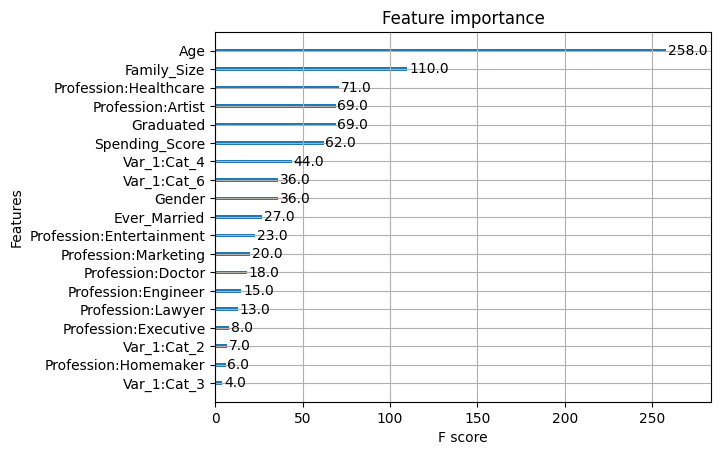

In [48]:
xgboost.plot_importance(grid_xgb.best_estimator_)
plt.show()

## Bagging

In [49]:
tune_xgb = xgboost.XGBClassifier(n_estimators=100, random_state=4649, tree_method='hist',
                                 max_depth=5, gamma=2, min_child_weight=1.5)

In [50]:
xgb_param_tune = {"subsample": np.arange(0.6, 1.0, 0.1),
                  "colsample_bytree": np.arange(0.3, 0.6, 0.1)}

In [51]:
grid_xgb_v2 = GridSearchCV(estimator=tune_xgb,
                           param_grid=xgb_param_tune,
                           scoring=["accuracy"],
                           refit="accuracy",
                           cv=cv_splitter,
                           verbose=1)
grid_xgb_v2.fit(X_train_std, y_train_label)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=2,
                                     grow_policy=None, importance_type...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1.5,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=4649, ...),
             param_grid={'colsample_bytree': array([0.3, 0.4, 0.5]),
                         'subsample': array([0.6, 0.7, 0.8, 0.9])},
             refit='accuracy', scoring=['accuracy'], verbose=1)

In [52]:
grid_xgb_v2_result = pd.DataFrame.from_dict(grid_xgb_v2.cv_results_)
grid_xgb_v2_result.sort_values(by="rank_test_accuracy")[["params", "mean_test_accuracy", "std_test_accuracy"]].head()

,params,mean_test_accuracy,std_test_accuracy
6,"{'colsample_bytree': 0.4, 'subsample': 0.79999...",0.538788,0.009615
10,"{'colsample_bytree': 0.5, 'subsample': 0.79999...",0.538159,0.013435
7,"{'colsample_bytree': 0.4, 'subsample': 0.89999...",0.537687,0.011548
4,"{'colsample_bytree': 0.4, 'subsample': 0.6}",0.536900,0.006247
9,"{'colsample_bytree': 0.5, 'subsample': 0.7}",0.535956,0.010963


In [53]:
grid_xgb_v2_result.sort_values(by="rank_test_accuracy")["params"][:5].values

array([{'colsample_bytree': 0.4, 'subsample': 0.7999999999999999},
       {'colsample_bytree': 0.5, 'subsample': 0.7999999999999999},
       {'colsample_bytree': 0.4, 'subsample': 0.8999999999999999},
       {'colsample_bytree': 0.4, 'subsample': 0.6},
       {'colsample_bytree': 0.5, 'subsample': 0.7}], dtype=object)

In [54]:
grid_xgb_v2_pred = le.inverse_transform(grid_xgb_v2.predict(X_test_std))
print(accuracy_score(y_test, grid_xgb_v2_pred))
print(classification_report(y_test, grid_xgb_v2_pred))

0.5481434864694776
              precision    recall  f1-score   support

           A       0.47      0.52      0.49       388
           B       0.43      0.32      0.37       367
           C       0.58      0.59      0.59       390
           D       0.66      0.72      0.69       444

    accuracy                           0.55      1589
   macro avg       0.53      0.54      0.53      1589
weighted avg       0.54      0.55      0.54      1589



# Confusion Matrix

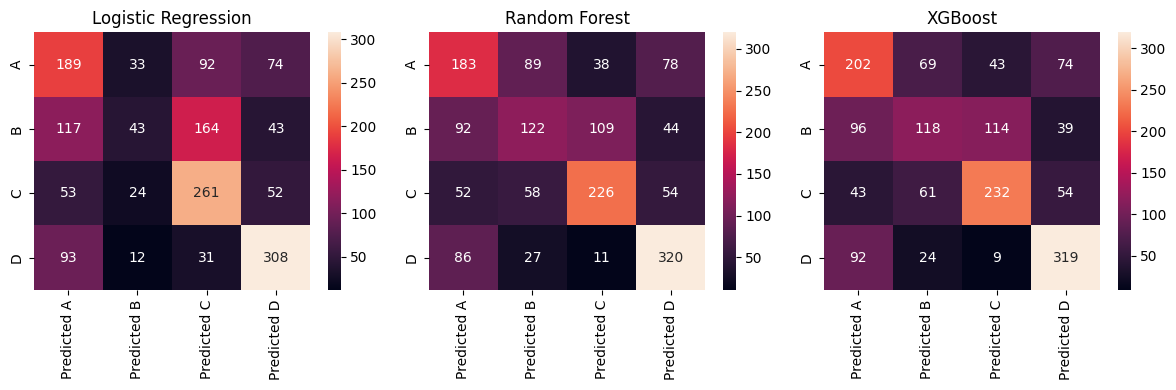

In [55]:
ordered_class = sorted(pd.unique(output_data))
conf_mat_logistic = pd.DataFrame(confusion_matrix(y_test, grid_logis_pred),
                                 index = ordered_class, columns = ['Predicted ' + x for x in ordered_class])
conf_mat_rf = pd.DataFrame(confusion_matrix(y_test, grid_rdf_pred),
                           index = ordered_class, columns = ['Predicted ' + x for x in ordered_class])
conf_mat_xgb = pd.DataFrame(confusion_matrix(y_test, grid_xgb_v2_pred),
                            index = ordered_class, columns = ['Predicted ' + x for x in ordered_class])

plt.figure(figsize = (12, 4))

for i, [conf_mat, name] in enumerate(zip([conf_mat_logistic, conf_mat_rf, conf_mat_xgb],
                                       ['Logistic Regression', 'Random Forest', 'XGBoost']), start = 1):
    plt.subplot(1, 3, i)
    sns.heatmap(conf_mat, annot = True, fmt = 'd')
    plt.title(name)

plt.tight_layout()
plt.show()

In [56]:
accuracy_scores = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, grid_logis_pred), accuracy_score(y_test, grid_rdf_pred), accuracy_score(y_test, grid_xgb_v2_pred)]
}

accuracy_df = pd.DataFrame(accuracy_scores)
accuracy_df

,Model,Accuracy
0,Logistic Regression,0.504091
1,Random Forest,0.535557
2,XGBoost,0.548143


# Sample Weight

In [90]:
x_tr, x_val, y_tr, y_val = train_test_split(X_train_std, y_train_label, test_size = 0.2, stratify = y_train, random_state = 4649)

In [91]:
sameple_weight = np.ones([len(y_tr), ])
sameple_weight

array([1., 1., 1., ..., 1., 1., 1.])

## weight on class B

In [94]:
sameple_weight[y_tr == 1] = 1.05
sameple_weight

array([1.  , 1.  , 1.  , ..., 1.05, 1.  , 1.  ])

In [95]:
len(sameple_weight)

5084

In [96]:
tuned_xgb_v3 = xgboost.XGBClassifier(n_estimators = 200, tree_method = 'hist', max_depth = 5, gamma = 2,
                                     min_child_weight = 2, colsample_bytree = 0.5, subsample = 0.8,
                                     eval_metric = ['merror', 'mlogloss'],
                                     early_stopping_rounds = 5)

tuned_xgb_v3.fit(x_tr, y_tr,
                 sample_weight = sameple_weight,
                 eval_set = [(x_tr, y_tr), (x_val, y_val)],
                 verbose = 0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [97]:
tuned_xgb_v3_pred = le.inverse_transform(tuned_xgb_v3.predict(X_test_std))
print(accuracy_score(y_test, tuned_xgb_v3_pred))

0.5349276274386406


In [98]:
weight_matrix = pd.DataFrame(confusion_matrix(y_test, tuned_xgb_v3_pred),
                           index = ordered_class, columns = ['Predicted ' + x for x in ordered_class])
weight_matrix


,Predicted A,Predicted B,Predicted C,Predicted D
A,182,96,37,73
B,81,127,112,47
C,39,80,217,54
D,81,25,14,324


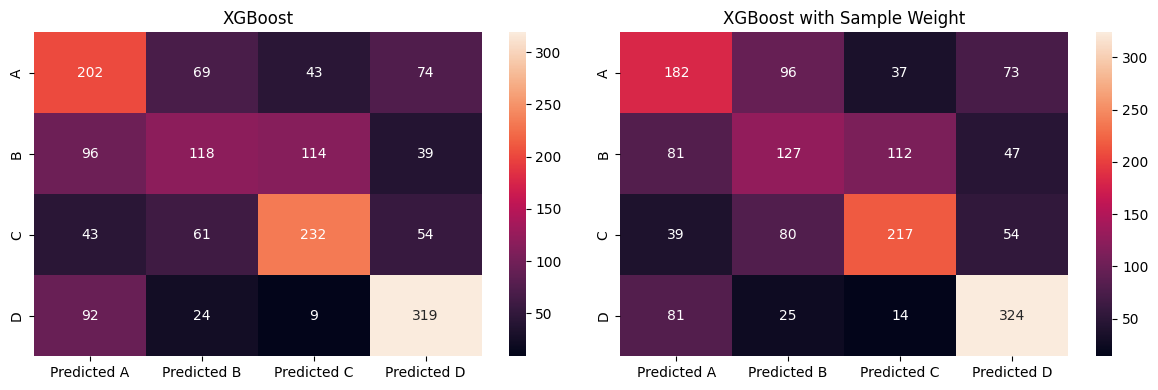

In [100]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
sns.heatmap(conf_mat_xgb, annot = True, fmt = 'd')
plt.title('XGBoost')
plt.subplot(1,2,2)
sns.heatmap(weight_matrix, annot = True, fmt = 'd')
plt.title('XGBoost with Sample Weight')
plt.tight_layout()
plt.show()

In [105]:
pd.value_counts(pd.Series(y_tr))

<ipython-input-105-a28395655332>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(pd.Series(y_tr))


,count
3,1418
2,1250
0,1241
1,1175


In [106]:
pd.value_counts(pd.Series(le.inverse_transform(y_tr)))

<ipython-input-106-dafe577e595b>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(pd.Series(le.inverse_transform(y_tr)))


,count
D,1418
C,1250
A,1241
B,1175
